# Failtech Learning: Tratamento e Análise Exploratória dos Dados 

Utilizando o conjunto de dados do Crunchbase para prever as chances de  uma startup falhar.

## Importando Bibliotecas

In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import re
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import pandas_profiling
%matplotlib inline

## Carregando datasets

In [2]:
companies_df = pd.read_csv('/home/lucas/startup_data/companies.csv')

additions_df = pd.read_csv('/home/lucas/startup_data/additions.csv')

acquisitions_df = pd.read_csv('/home/lucas/startup_data/acquisitions.csv')

investments_df = pd.read_csv('/home/lucas/startup_data/investments.csv')

rounds_df = pd.read_csv('/home/lucas/startup_data/rounds.csv')

## Limpando os dados

### Companies DataFrame

In [3]:
companies_df.shape

(66368, 14)

Remover startups sem a primeira data de financiamento

In [4]:
clean_companies_df = companies_df.dropna(subset=['first_funding_at'])
clean_companies_df.shape

(66344, 14)

**Remover startups sem nome**

In [5]:
clean_companies_df = clean_companies_df.dropna(subset=['name'])
clean_companies_df.shape

(66343, 14)

**Formatar datas**

Remover datas sem sentido (1532, por exemplo, estaria claramente fora de contexto)

In [6]:
# Os dois primeiros dígitos da coluna "first_funding_at" devem ser 19 ou 20
clean_companies_df = clean_companies_df[
    clean_companies_df.first_funding_at.str.match(r'(19)|(20)')]
clean_companies_df = clean_companies_df[
    clean_companies_df.last_funding_at.str.match(r'(19)|(20)')]
clean_companies_df.shape

(66338, 14)

In [7]:
clean_companies_df.first_funding_at = pd.to_datetime(
    clean_companies_df.loc[:, 'first_funding_at'])
clean_companies_df.last_funding_at = pd.to_datetime(
    clean_companies_df.loc[:, 'last_funding_at'])
clean_companies_df.shape

(66338, 14)

**Converter objetos numéricos**

In [8]:
# Preencher '-' com NaNs para ser tratado como numérico
clean_companies_df.funding_total_usd.replace('-', np.nan, inplace=True)

In [9]:
# Converter objetos em números
clean_companies_df.funding_total_usd = pd.to_numeric(
    clean_companies_df.loc[:, 'funding_total_usd'])

clean_companies_df.funding_rounds = pd.to_numeric(
    clean_companies_df.loc[:, 'funding_rounds'])

In [10]:
clean_companies_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 66338 entries, 0 to 66367
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   permalink          66338 non-null  object        
 1   name               66338 non-null  object        
 2   homepage_url       61280 non-null  object        
 3   category_list      63191 non-null  object        
 4   funding_total_usd  53555 non-null  float64       
 5   status             66338 non-null  object        
 6   country_code       59383 non-null  object        
 7   state_code         57794 non-null  object        
 8   region             58311 non-null  object        
 9   city               58313 non-null  object        
 10  funding_rounds     66338 non-null  int64         
 11  founded_at         51122 non-null  object        
 12  first_funding_at   66338 non-null  datetime64[ns]
 13  last_funding_at    66338 non-null  datetime64[ns]
dtypes: dat

In [11]:
clean_companies_df.status.value_counts()

operating    53008
closed        6235
acquired      5548
ipo           1547
Name: status, dtype: int64

In [12]:
# Remover colunas desnecessárias
clean_companies_df.drop(axis=1, columns=['homepage_url'], inplace=True)

In [13]:
# Salvar dataframe tratado
clean_companies_df.to_pickle('/home/lucas/startup_data/small_companies_df')

In [50]:
# Verificar quantas startups foram financiadas pela última vez há mais de 2,5 anos
clean_companies_df[np.logical_and(
    np.logical_and(clean_companies_df.last_funding_at < pd.to_datetime('2013'),
                   clean_companies_df.first_funding_at > '2005'),
    clean_companies_df.status == 'operating')]

,permalink,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at
3,/organization/0-6-com,0-6.com,Curated Web,2000000.0,operating,CHN,22,Beijing,Beijing,1,2007-01-01,2008-03-19,2008-03-19
6,/organization/0ndine-biomedical-inc,Ondine Biomedical Inc.,Biotechnology,762851.0,operating,CAN,BC,Vancouver,Vancouver,2,1997-01-01,2009-09-11,2009-12-21
12,/organization/1-800-dentist,1-800-DENTIST,Health and Wellness,NaN,operating,USA,CA,Los Angeles,Los Angeles,1,1986-01-01,2010-08-19,2010-08-19
13,/organization/1-800-doctors,1-800-DOCTORS,Health and Wellness,1750000.0,operating,USA,NJ,Newark,Iselin,1,1984-01-01,2011-03-02,2011-03-02
17,/organization/10-20-media,10-20 Media,E-Commerce,2050000.0,operating,USA,MD,Baltimore,Woodbine,4,2001-01-01,2009-06-18,2011-12-28
...,...,...,...,...,...,...,...,...,...,...,...,...,...
66339,/organization/zylie-the-bear,Zylie the Bear,E-Commerce,75000.0,operating,USA,CT,Hartford,Greenwich,1,2009-01-01,2012-06-07,2012-06-07
66346,/organization/zympi,Zympi,Mobile|Networking|Web Hosting,NaN,operating,USA,CA,Ontario - Inland Empire,Redlands,1,2010-09-03,2011-11-22,2011-11-22
66353,/organization/zyngenia,Zyngenia,Biotechnology,25000000.0,operating,USA,MD,"Washington, D.C.",Gaithersburg,1,2008-01-01,2010-09-09,2010-09-09
66359,/organization/zyrra,Zyrra,E-Commerce,1510500.0,operating,USA,MA,Boston,Cambridge,4,NaN,2010-10-21,2012-10-18


In [51]:
# Criar um dataset somente com as startups que falharam ou que tiveram sucesso

current_date = clean_companies_df.last_funding_at.max()

nonoperating_companies_df = clean_companies_df[np.logical_or(
    clean_companies_df.status != 'operating',
    np.logical_and(
        np.logical_and(
            clean_companies_df.status == 'operating',
            clean_companies_df.first_funding_at >
            current_date - pd.offsets.DateOffset(years=10)),
        clean_companies_df.last_funding_at < current_date -
        pd.offsets.DateOffset(years=2, months=6)))].reset_index()

In [52]:
nonoperating_companies_df.drop(columns='index', axis=1, inplace=True)

In [53]:
nonoperating_companies_df.shape

(32426, 13)

In [54]:
# Criar coluna com status binário (0 = closed, 1 = aqcquired/IPO)
nonoperating_companies_df['status_bool'] = np.nan

# Preencher a coluna
nonoperating_companies_df.loc[np.logical_or(
    nonoperating_companies_df.status == 'closed', nonoperating_companies_df.
    status == 'operating'), 'status_bool'] = 0
nonoperating_companies_df.loc[np.logical_or(
    nonoperating_companies_df.status == 'ipo', nonoperating_companies_df.status
    == 'acquired'), 'status_bool'] = 1

In [55]:
nonoperating_companies_df.status_bool.value_counts()

0.0    25331
1.0     7095
Name: status_bool, dtype: int64

In [56]:
# Quantas startups não têm informações de financiamento em dólares?
nonoperating_companies_df.funding_total_usd.isna().sum()

6605

In [57]:
nonoperating_companies_df.sample(5)

,permalink,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,status_bool
16955,/organization/mawell,Mawell,Information Technology,1.107578e+07,operating,GBR,H9,London,London,1,NaN,2007-09-12,2007-09-12,0.0
16505,/organization/m-a-com-technology-solutions,M/A-COM Technology Solutions,Mobile|Semiconductors,4.375175e+07,ipo,USA,MA,Boston,Lowell,1,NaN,2010-06-08,2010-06-08,1.0
25156,/organization/showthere,ShowThere,NaN,NaN,closed,NaN,NaN,NaN,NaN,1,2015-08-01,2015-08-01,2015-08-01,0.0
23780,/organization/riverwired,RiverWired,Networking|Social Media,1.500000e+06,operating,USA,NY,New York City,New York,1,NaN,2008-03-01,2008-03-01,0.0
16592,/organization/magellan-spine-technologies,Magellan Spine Technologies,Software,6.180600e+05,operating,USA,CA,Anaheim,Irvine,1,2006-01-01,2009-06-02,2009-06-02,0.0


### Rounds DataFrame

Este conjunto de dados contém informações sobre as rodadas de investimento para cada startup individualmente

In [58]:
rounds_df.shape

(114949, 12)

Foram eliminadas todas as linhas diferentes de pre-acquisition/pre-IPO

In [59]:
clean_rounds_df = rounds_df[np.logical_and(
    rounds_df.funding_round_type != 'post_ipo_equity',
    rounds_df.funding_round_type != 'post_ipo_debt')]

In [60]:
clean_rounds_df.shape

(114159, 12)

In [61]:
# Converter a coluna de data em objeto datetime
clean_rounds_df.funded_at = pd.to_datetime(clean_rounds_df.loc[:, 'funded_at'])

/home/lucas/.local/lib/python3.9/site-packages/pandas/core/generic.py:5491: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [62]:
clean_rounds_df.columns

Index(['company_permalink', 'company_name', 'company_category_list',
       'company_country_code', 'company_state_code', 'company_region',
       'company_city', 'funding_round_permalink', 'funding_round_type',
       'funding_round_code', 'funded_at', 'raised_amount_usd'],
      dtype='object')

In [63]:
clean_rounds_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 114159 entries, 0 to 114948
Data columns (total 12 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   company_permalink        114159 non-null  object        
 1   company_name             114158 non-null  object        
 2   company_category_list    110753 non-null  object        
 3   company_country_code     105509 non-null  object        
 4   company_state_code       103252 non-null  object        
 5   company_region           104028 non-null  object        
 6   company_city             104031 non-null  object        
 7   funding_round_permalink  114159 non-null  object        
 8   funding_round_type       114159 non-null  object        
 9   funding_round_code       31138 non-null   object        
 10  funded_at                114159 non-null  datetime64[ns]
 11  raised_amount_usd        94179 non-null   float64       
dtypes: datetime64[ns

## Atributos: tempo médio entre as rodadas, montante médio captado

In [64]:
# Ordenar o dataframe "rounds_df" por nome e data
clean_rounds_df.sort_values(by=['company_name', 'funded_at'],
                            ascending=True,
                            inplace=True)

<ipython-input-64-79eed32718a6>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_rounds_df.sort_values(by=['company_name', 'funded_at'],


In [65]:
# Criar coluna para o tempo entre as rodadas
clean_rounds_df['time_between_next_round'] = clean_rounds_df.groupby(
    'company_name').funded_at.diff()

<ipython-input-65-4d66adc8abe5>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_rounds_df['time_between_next_round'] = clean_rounds_df.groupby(


In [66]:
# Calcular o tempo médio entre as rodadas e o investimento médio levantado ($)

avg_round_time_amount = clean_rounds_df.groupby('company_name').agg({
    'time_between_next_round':
    pd.Series.mean,
    'raised_amount_usd':
    'mean'
}).rename(
    columns={
        'time_between_next_round': 'avg_time_bw_rounds',
        'raised_amount_usd': 'avg_raise_usd'
    }).reset_index()

In [67]:
# Fundir em um dataframe principal

nonoperating_companies_df = nonoperating_companies_df.merge(
    avg_round_time_amount, how='left', left_on='name', right_on='company_name')

### Atributos: tempo entre a primeira e a segunda rodada

In [68]:
# Criar coluna no dataframe principal
nonoperating_companies_df['time_bw_first_rounds'] = dt.timedelta(0)

for company in clean_rounds_df.company_name.unique():
    if len(clean_rounds_df[clean_rounds_df.company_name ==
                           company].funded_at) > 1:
        nonoperating_companies_df.loc[
            nonoperating_companies_df.name ==
            company, 'time_bw_first_rounds'] = clean_rounds_df[
                clean_rounds_df.company_name == company].funded_at.values[
                    1] - clean_rounds_df[clean_rounds_df.company_name ==
                                         company].funded_at.values[0]

In [69]:
nonoperating_companies_df.to_pickle('/home/lucas/startup_data/nonoperating_companies_df.pickle')
nonoperating_companies_df.to_pickle('/home/lucas/startup_data/df_before_categories.pickle')

### Atributos: Categorias

Analisar a distribuição de atributos entre as startups para ver se existem algumas que dominam. Note-se que para startups com múltiplas categorias estão listadas em ordem alfabética.

In [70]:
with open('/home/lucas/startup_data/nonoperating_companies_df.pickle', 'rb') as read_file:
    nonoperating_companies_df = pickle.load(read_file)

In [71]:
# Preencher categoria vazia com 'unknown'
nonoperating_companies_df.category_list.fillna('unknown', inplace=True)
# Criar coluna com lista de categorias
nonoperating_companies_df[
    'cat_list'] = nonoperating_companies_df.category_list.apply(str.split,
                                                                sep='|')

Verificar a distribuição das categorias

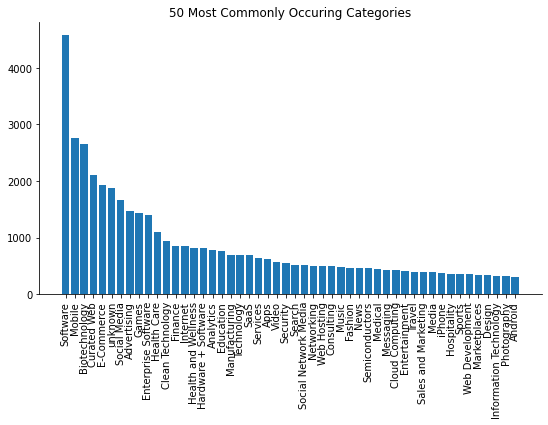

In [72]:
# Criar lista de listas de categorias
categories = list(nonoperating_companies_df.cat_list)
# Arrumar a lista
flat_categories = [cat for sublist in categories for cat in sublist]
# Contar as ocorrências de cada categoria
category_counts = Counter(flat_categories).most_common()
# Examinar a distribuição
plt.figure(figsize=(9, 5))
plt.bar([x[0] for x in category_counts[0:50]],
        [x[1] for x in category_counts[0:50]],
        width=0.8)
plt.xticks(rotation=90)
plt.title('50 Most Commonly Occuring Categories')
sns.despine()

In [73]:
# Ranking das Categorias (Top 25)
top_cats = [x[0] for x in category_counts[0:25]]

Para cada startup com uma categoria listada nas 25 primeiras categorias, substitua a sua "cat_list" por essa única categoria

In [74]:
nonoperating_companies_df.cat_list = nonoperating_companies_df.cat_list.map(
    lambda x: list(set(x) & set(top_cats))
    if set(x) & set(top_cats) else ['0_other_cat'])

Examinar novamente a distribuição por categorias com categorias simplificadas

Text(0.5, 1.0, 'Top Categories')

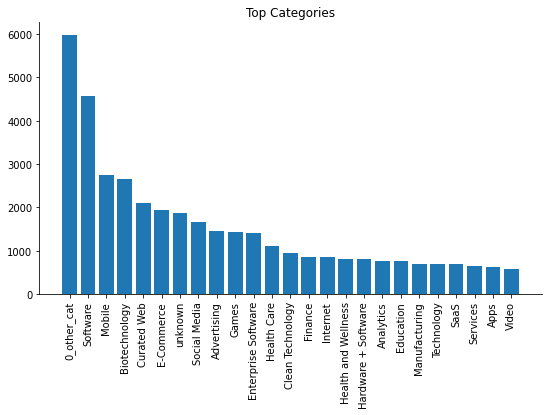

In [75]:
# Criar lista de listas de categorias
categories = list(nonoperating_companies_df.cat_list)
# Arrumar a lista
flat_categories = [cat for sublist in categories for cat in sublist]
# Contar as ocorrências de cada categoria
category_counts = Counter(flat_categories).most_common()
# Examinar a distribuição
plt.figure(figsize=(9, 5))
plt.bar([x[0] for x in category_counts[0:25]],
        [x[1] for x in category_counts[0:25]],
        width=0.8)
plt.xticks(rotation=90)
sns.despine()
plt.title('Top Categories')

In [76]:
# Isto será utilizado para criar variáveis fictícias na matriz de atributos
nonoperating_companies_df.cat_list = nonoperating_companies_df.cat_list.apply(
    lambda x: x[0])

In [77]:
nonoperating_companies_df.to_pickle('/home/lucas/startup_data/nonoperating_companies_df.pickle')

### Atributos: Localização

Analisar as distribuições de país, estado, região, cidade

In [78]:
# País
# Preencher país vazio com 'unknown'
nonoperating_companies_df.country_code.fillna('unknown', inplace=True)

Text(0.5, 1.0, 'Distribution of Top 10 Countries')

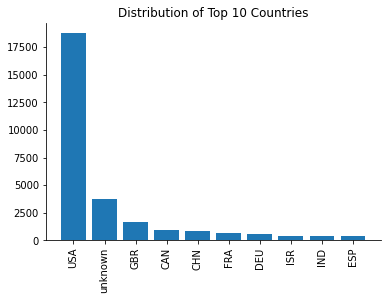

In [79]:
# Examinar distribuição
country_dist = nonoperating_companies_df.groupby(
    'country_code').size().sort_values(ascending=False)
plt.bar(country_dist[0:10].index, height=country_dist[0:10].values)
plt.xticks(rotation=90)
sns.despine()
plt.title('Distribution of Top 10 Countries')

In [80]:
# Países com mais de 500
top_countries = nonoperating_companies_df.groupby('country_code').size() > 300

# Startups de países com menos de 300 empresas vão para 'other'
nonoperating_companies_df[
    'country'] = nonoperating_companies_df.country_code.apply(
        lambda x: x if top_countries[x] else '0_other_country')

In [81]:
nonoperating_companies_df.to_pickle('/home/lucas/startup_data/nonoperating_companies_df.pickle')

In [82]:
nonoperating_companies_df[nonoperating_companies_df.funding_rounds ==
                          1].status.value_counts()

operating    14661
closed        4794
acquired      2664
ipo            646
Name: status, dtype: int64

### Atributos: Rodadas rotuladas (unfinished)
#### Seed Round
Verificar rodadas rotuladas como seed, venture e não rotuladas faz diferença na previsão do fracasso da startup.

In [87]:
def seed_code(row):
    """
    Helper Function:
    Replace code field with 'seed' if type field is 'seed'
    """
    if row['funding_round_type'] == 'seed':
        return 'seed'
    return row['funding_round_code']


# Criar nova coluna para isto
clean_rounds_df['round_code'] = clean_rounds_df.apply(seed_code, axis=1)

<ipython-input-87-62f7c78744bf>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_rounds_df['round_code'] = clean_rounds_df.apply(seed_code, axis=1)


In [88]:
# Converter a data de investimento em objeto datetime
clean_rounds_df.funded_at = pd.to_datetime(clean_rounds_df.loc[:, 'funded_at'])

In [89]:
# Agrupar por startup e rodadas por startup que segmentaram suas rodadas
company_round_groups = clean_rounds_df.groupby(['company_name',
                                                'round_code']).agg({
                                                    'funded_at':
                                                    'max',
                                                    'raised_amount_usd':
                                                    'sum'
                                                })
company_round_groups.reset_index(inplace=True)

In [90]:
# Seed dataframe
seed_df = company_round_groups[company_round_groups.round_code ==
                               'seed'].rename(
                                   columns={
                                       'company_name': 'name',
                                       'round_code': 'seed_bool',
                                       'funded_at': 'seed_date',
                                       'raised_amount_usd': 'seed_amount'
                                   })
seed_df.seed_bool = 1

In [91]:
# Preencher a coluna "seed_bool" em df para startups com um rótulo de rodada seed
seed_df['seed_bool'] = 0
seed_df.loc[seed_df.name.isin(seed_df.name.values), 'seed_bool'] = 1

In [92]:
seed_df.seed_bool.value_counts()

1    24944
Name: seed_bool, dtype: int64

In [93]:
nonoperating_companies_df.to_pickle('/home/lucas/startup_data/df.pickle')
seed_df.to_pickle('/home/lucas/startup_data/df.pickle')

## Corrigir 0 values para "nans"

In [94]:
with open('/home/lucas/startup_data/nonoperating_companies_df.pickle', 'rb') as read_file:
    df = pickle.load(read_file)

In [95]:
df.time_bw_first_rounds.replace(to_replace=dt.timedelta(days=0),
                                value=np.nan,
                                inplace=True)

### Limpando informações sobre data
Definir colunas de datas para 'float'

In [96]:
# Converter colunas timedelta para 'float' para modelos de classificação
df['float_avg_time_bw_rounds'] = df.avg_time_bw_rounds.dt.days
df['float_time_bw_first_rounds'] = df.time_bw_first_rounds.dt.days

## Outliers

In [97]:
# Armazenar o tamanho inicial do conjunto de dados
init_size = df.shape

In [98]:
df.describe()

,funding_total_usd,funding_rounds,status_bool,avg_time_bw_rounds,avg_raise_usd,time_bw_first_rounds,float_avg_time_bw_rounds,float_time_bw_first_rounds
count,2.582100e+04,32426.000000,32426.000000,9639,2.561800e+04,9433,9639.000000,9433.000000
mean,1.994869e+07,1.568494,0.218806,531 days 20:20:24.842320864,9.983271e+06,554 days 05:27:26.771970744,531.707957,554.227393
std,2.436003e+08,1.183781,0.413443,467 days 18:55:03.464741488,1.325715e+08,545 days 06:57:20.249379048,467.805388,545.289818
min,2.000000e+00,1.000000,0.000000,0 days 00:00:00,0.000000e+00,1 days 00:00:00,0.000000,1.000000
25%,3.600000e+05,1.000000,0.000000,250 days 15:00:00,3.000000e+05,226 days 00:00:00,250.000000,226.000000
50%,2.100000e+06,1.000000,0.000000,421 days 00:00:00,1.600000e+06,425 days 00:00:00,421.000000,425.000000
75%,1.093134e+07,2.000000,0.000000,671 days 00:00:00,6.705159e+06,722 days 00:00:00,671.000000,722.000000
max,3.007950e+10,18.000000,1.000000,8643 days 12:00:00,1.760000e+10,16477 days 00:00:00,8643.000000,16477.000000


O valor máximo para várias colunas é muito suspeito para o tempo entre as rodadas e o investimento levantado ($)

Text(0.5, 1.0, 'Total Raise Amount')

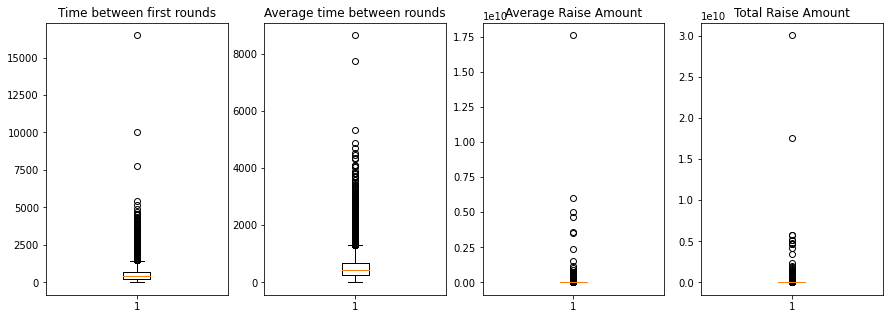

In [99]:
plt.subplots(1, 4, figsize=(15, 5))
plt.subplot(1, 4, 1)
plt.boxplot(
    df.float_time_bw_first_rounds[df.float_time_bw_first_rounds.notnull()])
plt.title('Time between first rounds')
plt.subplot(1, 4, 2)
plt.boxplot(df.float_avg_time_bw_rounds[df.float_avg_time_bw_rounds.notnull()])
plt.title('Average time between rounds')
plt.subplot(1, 4, 3)
plt.boxplot(df.avg_raise_usd[df.avg_raise_usd.notnull()])
plt.title('Average Raise Amount')
plt.subplot(1, 4, 4)
plt.boxplot(df.funding_total_usd[df.funding_total_usd.notnull()])
plt.title('Total Raise Amount')

Estes estão fortemente inclinados para a direita - tentou-se remover alguns outliers

In [100]:
def findOutliers(df, column, lim_scalar=1.5):
    """
    Returns outliers above the max limit for a column in a dataframe
    Adjust outlier cutoff to q75 + 4*iqr to include more data
    ---
    input: DataFrame, column(series),lim_scalar(float)
    output: DataFrame
    """
    q25, q50, q75 = df[column].quantile(q=[0.25, 0.5, 0.75])
    iqr = q75 - q25
    # limites máximos para ser considerado como um outlier
    max = q75 + lim_scalar * iqr
    # identificar os pontos
    outlier_mask = [True if x > max else False for x in df[column]]
    print(
        '{} outliers found out of {} data points, {:.2f}% of the data'.format(
            sum(outlier_mask), len(df[column]),
            100 * (sum(outlier_mask) / len(df[column]))))
    return outlier_mask

In [101]:
print('Funding total $: ')
fund_total_outlier_mask = pd.Series(
    findOutliers(df, 'funding_total_usd', lim_scalar=3))
print('Average round $: ')
avg_raise_outlier_mask = pd.Series(
    findOutliers(df, 'avg_raise_usd', lim_scalar=3))
print('Time between first rounds: ')
first_time_outlier_mask = pd.Series(
    findOutliers(df, 'float_time_bw_first_rounds', lim_scalar=1.5))
print('Average time between rounds: ')
avg_time_outlier_mask = pd.Series(
    findOutliers(df, 'float_avg_time_bw_rounds', lim_scalar=1.5))

Funding total $: 
2123 outliers found out of 32426 data points, 6.55% of the data
Average round $: 
1498 outliers found out of 32426 data points, 4.62% of the data
Time between first rounds: 
470 outliers found out of 32426 data points, 1.45% of the data
Average time between rounds: 
543 outliers found out of 32426 data points, 1.67% of the data


Muitas sobreposições sobre estes pontos. Remover os outliers.

In [102]:
# Retirar outliers
clean_df1 = df[~fund_total_outlier_mask]
clean_df2 = df[~avg_raise_outlier_mask]
clean_df3 = df[~first_time_outlier_mask]
clean_df4 = df[~avg_time_outlier_mask]

clean_df = clean_df1.merge(clean_df2,
                           left_on=list(df.columns),
                           right_on=list(df.columns),
                           how='inner')
clean_df = clean_df.merge(clean_df3,
                          left_on=list(df.columns),
                          right_on=list(df.columns),
                          how='inner')
clean_df = clean_df.merge(clean_df4,
                          left_on=list(df.columns),
                          right_on=list(df.columns),
                          how='inner')

In [103]:
print('Removed {} outliers, {:.2f}% of the original dataset'.format(
    (init_size[0] - clean_df.shape[0]), 100 *
    ((init_size[0] - clean_df.shape[0]) / (init_size[0] + clean_df.shape[0]))))

Removed 3004 outliers, 4.86% of the original dataset


In [104]:
clean_df.to_pickle('/home/lucas/startup_data/clean_df.pickle')

In [105]:
clean_df.describe()

,funding_total_usd,funding_rounds,status_bool,avg_time_bw_rounds,avg_raise_usd,time_bw_first_rounds,float_avg_time_bw_rounds,float_time_bw_first_rounds
count,2.284600e+04,29422.000000,29422.000000,7659,2.273300e+04,7472,7659.000000,7472.000000
mean,5.243217e+06,1.438651,0.184182,436 days 14:54:13.151985224,3.324563e+06,447 days 02:29:44.582441112,436.501632,447.103988
std,8.040261e+06,0.949003,0.387639,280 days 13:34:11.088023652,4.756288e+06,306 days 10:57:54.058703764,280.574769,306.456876
min,2.000000e+00,1.000000,0.000000,0 days 00:00:00,0.000000e+00,1 days 00:00:00,0.000000,1.000000
25%,2.672890e+05,1.000000,0.000000,228 days 00:00:00,2.500000e+05,211 days 00:00:00,228.000000,211.000000
50%,1.500000e+06,1.000000,0.000000,389 days 18:00:00,1.167697e+06,389 days 12:00:00,389.000000,389.500000
75%,6.600000e+06,2.000000,0.000000,599 days 18:00:00,4.523083e+06,633 days 00:00:00,599.500000,633.000000
max,4.260000e+07,18.000000,1.000000,1302 days 00:00:00,2.580000e+07,1462 days 00:00:00,1302.000000,1462.000000
